# 우수게임별 워드클라우드 EDA

## 목적
- 게임별 텍스트 특성 확인 → 긍·부정 핵심 키워드 비교

## 절차
1. 데이터 준비
  - 라벨 컬럼 추가
  - train/test로 나누기
  - 전처리 및 피클파일 저장

2. 워드클라우드 생성
  - 게임별 감성 비율
  - 긍정 리뷰 워드클라우드 (게임별 따로 시각화)
  - 부정 리뷰 워드클라우드 (게임별 따로 시각화)

3. 텍스트 비교
  - 3개 긍정 워드클라우드를 한 줄에 배치
  - 3개 부정 워드클라우드를 한 줄에 배치
  - 공통 키워드 vs 게임 고유 키워드 도출

4. 요약 인사이트
  - 게임별 만족 요인/불만 요인 비교

## 1. 데이터 준비

In [41]:
import pandas as pd

In [42]:
mr_reviews = pd.read_csv("33-1. Marvel Rivals_reviews_정제.csv", encoding='utf-8-sig')
rdr_reviews = pd.read_csv("34-1. RDR2_reviews_정제.csv", encoding='utf-8-sig')
pubg_reviews = pd.read_csv("35-1. PUBG_reviews_정제.csv", encoding='utf-8-sig')

In [43]:
# id와 리뷰 본문만 추출
mr_text = mr_reviews[['닉네임','본문_번역']]
rdr_text = rdr_reviews[['닉네임','본문_번역']]
pubg_text = pubg_reviews[['닉네임','본문_번역']]

### 라벨 컬럼 추가
* VADER 약라벨 생성
    * VADER? - 수작업으로 라벨링된 데이터가 없는 상황에서 긍/부정을 빠르게 분류
    * 학습에 필요한 모델이 아님
        * 전체 데이터에 적용하여 감성 점수 부여.
        * 이 점수를 나중에 지도 학습 모델의 훈련 데이터로 활용 가능

In [44]:
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [45]:
# VADER 준비 (최초 1회만 필요)
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:
# 함수: 감성 점수 → 라벨
def vader_label(text):
    comp = sia.polarity_scores(str(text))['compound']
    if comp >= 0.05:
        return 'positive'
    elif comp <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [47]:
# 약라벨 컬럼 생성
mr_text['vader_label'] = mr_text['본문_번역'].apply(vader_label)
mr_text['compound'] = mr_text['본문_번역'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

rdr_text['vader_label'] = rdr_text['본문_번역'].apply(vader_label)
rdr_text['compound'] = rdr_text['본문_번역'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

pubg_text['vader_label'] = pubg_text['본문_번역'].apply(vader_label)
pubg_text['compound'] = pubg_text['본문_번역'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

C:\Users\user\AppData\Local\Temp\ipykernel_19476\3165702927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mr_text['vader_label'] = mr_text['본문_번역'].apply(vader_label)
C:\Users\user\AppData\Local\Temp\ipykernel_19476\3165702927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mr_text['compound'] = mr_text['본문_번역'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
C:\Users\user\AppData\Local\Temp\ipykernel_19476\3165702927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [48]:
mr_text = mr_text.dropna(subset=["본문_번역"]).reset_index(drop=True)
rdr_text = rdr_text.dropna(subset=["본문_번역"]).reset_index(drop=True)
pubg_text = pubg_text.dropna(subset=["본문_번역"]).reset_index(drop=True)

In [49]:
# 절대값이 작은 샘플은 제거해서 신뢰도를 높임
mr_filt = mr_text[mr_text["compound"].abs() >= 0.2].reset_index(drop=True)
rdr_filt = rdr_text[rdr_text["compound"].abs() >= 0.2].reset_index(drop=True)
pubg_filt = pubg_text[pubg_text["compound"].abs() >= 0.2].reset_index(drop=True)

In [50]:
# neutral 라벨 제거 - 긍정/부정만 남은 이진 분류 전용 데이터프레임을 만듦
mr_bin_df = mr_filt[mr_filt["vader_label"] != "neutral"].reset_index(drop=True)
rdr_bin_df = rdr_filt[rdr_filt["vader_label"] != "neutral"].reset_index(drop=True)
pubg_bin_df = pubg_filt[pubg_filt["vader_label"] != "neutral"].reset_index(drop=True)

In [51]:
# nagative:0, positive:1로 고치기 -  딥러닝 모델 학습용 레이블로 사용 가능
mr_bin_df["label_id"] = mr_bin_df["vader_label"].map({"negative":0, "positive":1})
rdr_bin_df["label_id"] = rdr_bin_df["vader_label"].map({"negative":0, "positive":1})
pubg_bin_df["label_id"] = pubg_bin_df["vader_label"].map({"negative":0, "positive":1})

In [52]:
# 데이터 긍/부정 비율 확인
print(mr_bin_df["vader_label"].value_counts())
print(rdr_bin_df["vader_label"].value_counts())
print(pubg_bin_df["vader_label"].value_counts())

vader_label
positive    13603
negative     4990
Name: count, dtype: int64
vader_label
positive    5719
negative    1175
Name: count, dtype: int64
vader_label
positive    7966
negative    1541
Name: count, dtype: int64


### train/test로 나누기

* train_df : 학습용 80%
* valid_df : 검증용 10%
* test_df : 최종 평가용 10%

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
# train 떼어내기

# Marvel Rivals
mr_train, mr_test = train_test_split(
    mr_bin_df, test_size=0.2, random_state=42, stratify=mr_bin_df["label_id"])

# Red Dead Redemption 2
rdr_train, rdr_test = train_test_split(
    rdr_bin_df, test_size=0.2, random_state=42, stratify=rdr_bin_df["label_id"])

# PUBG
pubg_train, pubg_test = train_test_split(
    pubg_bin_df, test_size=0.2, random_state=42, stratify=pubg_bin_df["label_id"])

In [55]:
# temp_df를 valid/test로 나누기

# Marvel Rivals
mr_train, mr_temp = train_test_split(
    mr_bin_df, test_size=0.2, random_state=42, stratify=mr_bin_df["label_id"])
mr_valid, mr_test = train_test_split(
    mr_temp, test_size=0.5, random_state=42, stratify=mr_temp["label_id"])

# Red Dead Redemption 2
rdr_train, rdr_temp = train_test_split(
    rdr_bin_df, test_size=0.2, random_state=42, stratify=rdr_bin_df["label_id"])
rdr_valid, rdr_test = train_test_split(
    rdr_temp, test_size=0.5, random_state=42, stratify=rdr_temp["label_id"])

# PUBG
pubg_train, pubg_temp = train_test_split(
    pubg_bin_df, test_size=0.2, random_state=42, stratify=pubg_bin_df["label_id"])
pubg_valid, pubg_test = train_test_split(
    pubg_temp, test_size=0.5, random_state=42, stratify=pubg_temp["label_id"])

### 전처리

In [56]:
EMOJI_RE = re.compile(
    "[" 
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002700-\U000027BF"
    u"\U0001F900-\U0001F9FF"
    u"\U00002600-\U000026FF"
    u"\U00002B00-\U00002BFF"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)

URL_RE      = re.compile(r"(https?://\S+|www\.\S+)")
EMAIL_RE    = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
HTML_TAG_RE = re.compile(r"<[^>]+>")
USER_MENT_RE= re.compile(r"@\w+")        # @user
HASHTAG_RE  = re.compile(r"#(\w+)")      # #word -> word
WS_RE       = re.compile(r"\s+")

In [57]:
def clean_text(s: str) -> str:
    s = str(s)
    s = URL_RE.sub(" ", s)
    s = EMAIL_RE.sub(" ", s)
    s = HTML_TAG_RE.sub(" ", s)
    s = USER_MENT_RE.sub(" ", s)
    s = HASHTAG_RE.sub(r"\1", s)         # 해시태그 기호만 제거, 단어는 보존
    s = EMOJI_RE.sub(" ", s)
    # 스마트 따옴표 등 통일(선택)
    s = s.replace("’","'").replace("“","\"").replace("”","\"")
    # 소문자화 (DistilBERT-uncased와 일관성)
    s = s.lower()
    # 공백 정리
    s = WS_RE.sub(" ", s).strip()
    return s

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

def train_and_evaluate(train_df, valid_df, test_df, game_name):
    # 파이프라인 정의
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1,2),
            min_df=2, max_df=0.95,
            sublinear_tf=True,
            stop_words="english"
        )),
        ("clf", LinearSVC(class_weight="balanced", random_state=42))
    ])

    # 학습
    pipe.fit(train_df["본문_번역"], train_df["label_id"])

    # 검증 성능
    val_pred = pipe.predict(valid_df["본문_번역"])
    test_pred = pipe.predict(test_df["본문_번역"])

    print(f"\n===== {game_name} =====")
    print("VALID acc:", accuracy_score(valid_df["label_id"], val_pred),
          "f1:", f1_score(valid_df["label_id"], val_pred))
    print("TEST  acc:", accuracy_score(test_df["label_id"], test_pred),
          "f1:", f1_score(test_df["label_id"], test_pred))
    print(classification_report(test_df["label_id"], test_pred, digits=4))

    return pipe

# Marvel Rivals
mr_model = train_and_evaluate(mr_train, mr_valid, mr_test, "Marvel Rivals")

# Red Dead Redemption 2
rdr_model = train_and_evaluate(rdr_train, rdr_valid, rdr_test, "Red Dead Redemption 2")

# PUBG
pubg_model = train_and_evaluate(pubg_train, pubg_valid, pubg_test, "PUBG")



===== Marvel Rivals =====
VALID acc: 0.9090909090909091 f1: 0.9370577281191806
TEST  acc: 0.8956989247311828 f1: 0.9277736411020104
              precision    recall  f1-score   support

           0     0.7850    0.8417    0.8124       499
           1     0.9404    0.9155    0.9278      1361

    accuracy                         0.8957      1860
   macro avg     0.8627    0.8786    0.8701      1860
weighted avg     0.8987    0.8957    0.8968      1860


===== Red Dead Redemption 2 =====
VALID acc: 0.9056603773584906 f1: 0.9429323968393327
TEST  acc: 0.8985507246376812 f1: 0.9383802816901409
              precision    recall  f1-score   support

           0     0.6905    0.7373    0.7131       118
           1     0.9450    0.9318    0.9384       572

    accuracy                         0.8986       690
   macro avg     0.8178    0.8346    0.8257       690
weighted avg     0.9015    0.8986    0.8999       690


===== PUBG =====
VALID acc: 0.935856992639327 f1: 0.9610721123165284
TE

In [59]:
# 각 split에 전처리 열 추가 (원문은 보존)

def preprocess_df(df, text_col="text"):
    out = df.copy()
    out[text_col] = out[text_col].astype(str)
    out["text_clean"] = out[text_col].apply(clean_text)
    out = out.dropna(subset=["text_clean"])
    out = out[out["text_clean"].str.len() > 0].reset_index(drop=True)
    return out

# 세 게임의 split들을 딕셔너리로 묶기
splits = {
    "mr":  {"train": mr_train,  "valid": mr_valid,  "test": mr_test},
    "rdr": {"train": rdr_train, "valid": rdr_valid, "test": rdr_test},
    "pubg":{"train": pubg_train,"valid": pubg_valid,"test": pubg_test},
}

# 일괄 전처리
for game_key, parts in splits.items():
    for split_name, df in parts.items():
        parts[split_name] = preprocess_df(df, text_col="본문_번역")

# 다시 변수로 풀어놓기 (원하면)
mr_train, mr_valid, mr_test       = splits["mr"]["train"],  splits["mr"]["valid"],  splits["mr"]["test"]
rdr_train, rdr_valid, rdr_test    = splits["rdr"]["train"], splits["rdr"]["valid"], splits["rdr"]["test"]
pubg_train, pubg_valid, pubg_test = splits["pubg"]["train"],splits["pubg"]["valid"],splits["pubg"]["test"]

In [60]:
import pickle

# 저장
def save_pickle(obj, filename):
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
    print(f"저장 완료: {filename}")

# Marvel Rivals
save_pickle(mr_train, "41-0. mr_train.pkl")
save_pickle(mr_valid, "41-0. mr_valid.pkl")
save_pickle(mr_test,  "41-0. mr_test.pkl")

# Red Dead Redemption 2
save_pickle(rdr_train, "41-0. rdr_train.pkl")
save_pickle(rdr_valid, "41-0. rdr_valid.pkl")
save_pickle(rdr_test,  "41-0. rdr_test.pkl")

# PUBG
save_pickle(pubg_train, "41-0. pubg_train.pkl")
save_pickle(pubg_valid, "41-0. pubg_valid.pkl")
save_pickle(pubg_test,  "41-0. pubg_test.pkl")

저장 완료: 41-0. mr_train.pkl
저장 완료: 41-0. mr_valid.pkl
저장 완료: 41-0. mr_test.pkl
저장 완료: 41-0. rdr_train.pkl
저장 완료: 41-0. rdr_valid.pkl
저장 완료: 41-0. rdr_test.pkl
저장 완료: 41-0. pubg_train.pkl
저장 완료: 41-0. pubg_valid.pkl
저장 완료: 41-0. pubg_test.pkl


## 2. 긍/부정 워드클라우드

### a. 게임별 감성 비율

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from collections import Counter
from deep_translator import MyMemoryTranslator
from matplotlib import font_manager

In [62]:
label2id = {"negative": 0, "positive": 1, "neutral": 2}

def map_labels(df, col="vader_label"):
    out = df.copy()
    # 문자열/숫자 모두 매핑
    out[col] = out[col].map(label2id)
    # 매핑 안 된 값(NaN) 제거
    out = out.dropna(subset=[col]).reset_index(drop=True)
    # int 변환
    out[col] = out[col].astype(int)
    return out

# 게임별로 매핑 적용
mr_text_m   = map_labels(mr_text,  "vader_label")
pubg_text_m = map_labels(pubg_text,"vader_label")
rdr_text_m  = map_labels(rdr_text, "vader_label")

# 변환 결과 확인
display(mr_text_m["vader_label"].value_counts())
display(pubg_text_m["vader_label"].value_counts())
display(rdr_text_m["vader_label"].value_counts())

vader_label
1    14209
2     6188
0     5574
Name: count, dtype: int64

vader_label
2    8526
1    8184
0    1742
Name: count, dtype: int64

vader_label
1    5881
2    3462
0    1282
Name: count, dtype: int64

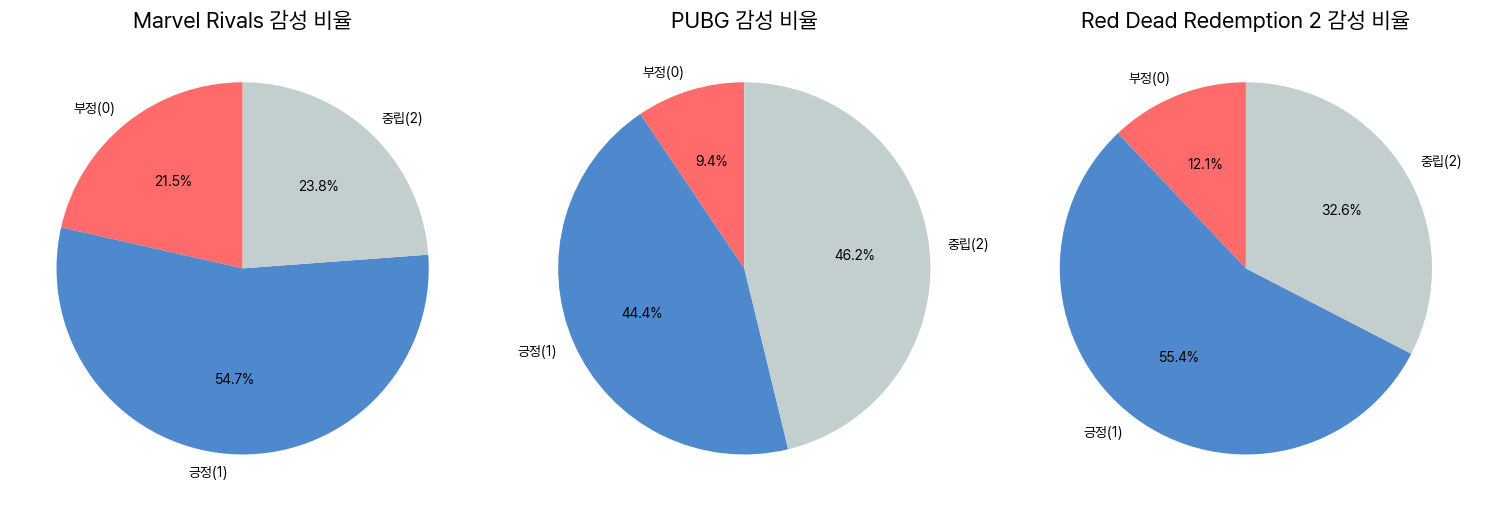

In [45]:
# 색상 고정 (부정=빨강, 긍정=파랑, 중립=회색)
sentiment_colors = {0: "#FF6B6B", 1: "#4E89CD", 2: "#C3CECE"}

# 세 게임 데이터프레임과 제목 묶기
game_datasets = [
    (mr_text_m, "Marvel Rivals"),
    (pubg_text_m, "PUBG"),
    (rdr_text_m, "Red Dead Redemption 2")
]

# 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for ax, (df, title) in zip(axes, game_datasets):
    counts = df["vader_label"].value_counts().sort_index()
    labels = ["부정(0)", "긍정(1)", "중립(2)"]
    
    ax.pie(
        counts,
        labels=labels,
        autopct="%.1f%%",
        startangle=90,
        colors=[sentiment_colors[i] for i in counts.index])
    ax.set_title(f"{title} 감성 비율", fontsize=16)

plt.tight_layout()
plt.show()

- Marvel Rivals
    - 긍정(1): 54.7%
    - 부정(0): 21.5%
    - 중립(2): 23.8%
>> 긍정이 과반이지만 부정+중립 합계가 45%를 차지함.
<br>신규 게임 특성상 불안정한 요소(서버/밸런스/최적화)에 대한 반응이 혼재되어 있을 가능성이 있음

- PUBG
    - 긍정(1): 44.4%
    - 부정(0): 9.4%
    - 중립(2): 46.2%
>> 중립 비율이 가장 높음(46%)
<br>장기 서비스 게임이라 극단적인 호불호보다는 무난한 리뷰가 많음

- Red Dead Redemption 2
    - 긍정(1): 55.4%
    - 부정(0): 12.1%
    - 중립(2): 32.6%
>> 세 게임 중 긍정률이 가장 높음.
<br>스토리/그래픽/몰입감에 대한 확실한 강점 덕분에 장기적으로 호평이 유지되는 듯 함.
<br>그러나 중립도 적지 않아, 경험은 좋지만 또 할지는 모르겠다는 의견도 존재할 가능성이 있음

### b. Marvel Rivals 워드클라우드

In [47]:
# 리뷰 텍스트와 라벨만 따로 빼기
mr_pn_word = mr_text_m[['본문_번역', 'vader_label']]

In [49]:
# 중립 제외하기
mr_pn_word = mr_pn_word[mr_pn_word['vader_label'].isin([0, 1])].copy()

In [50]:
import re
import numpy as np

def clean_text(text):
    # 문자열 변환
    text = str(text)
    
    # 한글, 영어, 공백만 남기기 (숫자, 특수문자 제거)
    text = re.sub(r'[^가-힣a-zA-Z\s]', ' ', text)
    
    # 다중 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 최종적으로 빈 문자열이면 NaN 반환 (필터링 가능)
    if text == "":
        return np.nan
    return text

In [51]:
mr_pn_word["본문_번역"] = mr_pn_word["본문_번역"].apply(clean_text)
mr_pn_word = mr_pn_word.dropna(subset=["본문_번역"]).reset_index(drop=True)

In [54]:
# 긍/부정 텍스트 합치기
mr_pos_texts = mr_pn_word[mr_pn_word['vader_label'] == 1]['본문_번역'].apply(clean_text)
mr_neg_texts = mr_pn_word[mr_pn_word['vader_label'] == 0]['본문_번역'].apply(clean_text)
print(len(mr_pos_texts), len(mr_neg_texts))

14209 5574


In [55]:
# TF-IDF로 상위 키워드 뽑기 (uni/bi-gram)
# Term Frequency,단어 빈도/ Inverse Document Frequency, 역문서 빈도
# 자주 나오지만 흔하지 않은 단어 → 높은 점수
# 자주 나오지만 흔한 단어 → 낮은 점수
from sklearn.feature_extraction.text import TfidfVectorizer

def top_keywords(texts, topk=30, ngram=(1,2)):
    # Series일 경우 리스트로 변환
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()
    if len(texts) == 0:
        return []

    vec = TfidfVectorizer(
        max_features=20000,
        ngram_range=ngram,
        stop_words='english'  # 영어 불용어 제거
    )
    X = vec.fit_transform(texts)
    vocab = vec.get_feature_names_out()
    scores = X.mean(axis=0).A1
    order = scores.argsort()[::-1][:topk]
    return [(vocab[i], float(scores[i])) for i in order]

# 사용 예시
mr_pos_kw = top_keywords(mr_pos_texts, topk=300, ngram=(1,2))
mr_neg_kw = top_keywords(mr_neg_texts, topk=300, ngram=(1,2))

print("POS top 5:", mr_pos_kw[:5])
print("NEG top 5:", mr_neg_kw[:5])

POS top 5: [('good', 0.07748977147549102), ('game', 0.06143064756685607), ('fun', 0.058458268024999656), ('free', 0.03125336332707017), ('product', 0.03016481612612943)]
NEG top 5: [('game', 0.055911862449445134), ('bad', 0.02688256749448781), ('matchmaking', 0.025425938294200888), ('play', 0.01973851931504207), ('ass', 0.017527996617878717)]


In [56]:
# 키워드 한글 번역 (무료 번역기 예시)

from deep_translator import MyMemoryTranslator

translator = MyMemoryTranslator(source='english', target='korean')

def translate_list(pairs):
    # pairs: [(keyword, score), ...]
    out = []
    for w, s in pairs:
        try:
            ko = translator.translate(w)
        except Exception:
            ko = ""  # 실패 시 빈 문자열
        out.append((w, ko, s))
    return out

mr_pos_kw_ko = translate_list(mr_pos_kw)
mr_neg_kw_ko = translate_list(mr_neg_kw)

# 미리보기
for w, ko, sc in mr_pos_kw_ko[:10]:
    print(f"[POS] {w} -> {ko} ({sc:.4f})")
for w, ko, sc in mr_neg_kw_ko[:10]:
    print(f"[NEG] {w} -> {ko} ({sc:.4f})")

[POS] good -> 선 (0.0775)
[POS] game -> 게임을 (0.0614)
[POS] fun -> 재밌는 (0.0585)
[POS] free -> 무료 (0.0313)
[POS] product -> 상품 (0.0302)
[POS] received -> 지불됨 (0.0299)
[POS] product received -> 제품 수령 완료 (0.0299)
[POS] received free -> 무료로 받음 (0.0299)
[POS] good game -> 멋져요 (0.0260)
[POS] play -> 플레이 (0.0239)
[NEG] game -> 게임을 (0.0559)
[NEG] bad -> 나쁨 (0.0269)
[NEG] matchmaking -> 매치메이킹 (0.0254)
[NEG] play -> 플레이 (0.0197)
[NEG] ass -> 나귀 (0.0175)
[NEG] hate -> 증오 (0.0167)
[NEG] eomm -> eomm (0.0164)
[NEG] sucks -> 짜증나네요… (0.0141)
[NEG] just -> 오직 (0.0139)
[NEG] worst -> 최악 (0.0131)


In [57]:
pos_df_kw = pd.DataFrame(mr_pos_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])
neg_df_kw = pd.DataFrame(mr_neg_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])

pos_df_kw.to_csv("41-1. MR_리뷰_긍정단어.csv", index=False, encoding="utf-8-sig")
neg_df_kw.to_csv("41-1. MR_리뷰_부정단어.csv", index=False, encoding="utf-8-sig")

print("저장 완료: 41-1. MR_리뷰_긍정단어.csv / 41-1. MR_리뷰_부정단어.csv")

저장 완료: 41-1. MR_리뷰_긍정단어.csv / 41-1. MR_리뷰_부정단어.csv


#### 긍정

In [58]:
pos_df_kw = pd.read_csv("41-1. MR_리뷰_긍정단어.csv", encoding="utf-8-sig")

In [89]:
pos_df_kw[291:300]

,keyword_en,keyword_ko,tfidf_mean
291,maps,지도,0.001341
292,game lot,게임 로트,0.001336
293,art,미술,0.001330
294,trying,시도중,0.001329
295,role,역할,0.001314
296,winning,낙찰!,0.001313
297,issue,결과,0.001311
298,shark,상어,0.001311
299,maybe,아마도,0.001304


In [92]:
pos_df_kw = pos_df_kw.drop([0,1,2,3,8,9
                            ,11,12,14,15,16,17,18,19
                            ,22,23,26,27,28
                            ,32,33,35,37,39
                            ,42,44,45,46,48
                            ,53,55,56,58,59
                            ,61,63,64,65,67,68,69
                            ,71,72,73,75,76,77,78,79
                            ,81,82,85,86,87
                            ,91,94,95,96,98,99
                            ,103,105,106,109
                            ,111,114,117,118,119
                            ,121,122,123,126,127,129
                            ,132,133,136,137,139
                            ,141,143,144,145,146,147,149
                            ,151,152,154,155,158
                            ,161,162,163,164,165,166,168
                            ,171,172,173,174,175,176,178
                            ,181,182,183,185,187
                            ,191,192,193,194,195,196,198
                            ,202,203,204,205,206,207,208
                            ,212,213,214,215,216,217,219
                            ,221,222,223,224,225,229
                            ,231,232,233,234,235,236,238
                            ,241,242,243,244,245,247,248,249
                            ,251,253,254,255,256,257,258,259
                            ,261,262,263,264,265,266,267,269
                            ,271,272,273,274,276,277,278
                            ,282,283,284,287,288,289
                            ,292,294,296,297,298,299]).reset_index(drop=True)

In [ ]:
pos_df_kw = pos_df_kw.drop([0,1,2,3,4,5,6]).reset_index(drop=True)

In [98]:
pos_df_kw = pos_df_kw.drop([6,8,9]).reset_index(drop=True)

In [103]:
pos_df_kw[81:100]

,keyword_en,keyword_ko,tfidf_mean
81,updates,업데이트,0.001562
82,definitely,명확히,0.001555
83,problem,문제,0.001520
84,update,업데이트,0.001519
85,far,먼,0.001517
86,solo,솔로,0.001502
87,enjoyable,즐길만한,0.001486
88,mode,모드,0.001484
89,spider man,스파이더맨,0.001453
90,balancing,균형 조정,0.001427


In [104]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].replace({
    "문자": "캐릭터",
    "시간": "플레이 시간",
    "백성": "사람들",
    "경쟁적인":"경쟁",
    "싶다": "원하다",
    "히어로 슈팅 게임":"히어로 슈팅",
    "재생": "플레이",
    "우승": "승리",
    "게임 플레이": "게임플레이",
    "인물": "캐릭터",
    "community": "커뮤니티",
    "영웅": "영웅들",
    "경험하다": "체감",
    "필요성": "필요",
    "앎": "알다",
    "최적화됨": "최적화",
    "게임처럼": "게임 같다",
    "사실은": "실제로",
    "기준": "기반",
    "상실하다": "패배",
    "가져오는중": "얻다",
    "기술": "스킬",
    "약혼": "몰입도",
    "재미있는 친구들": "친구랑 재밌게",
    "favorite": "즐겨찾는",
    "support": "지원",
    "빠른 재생": "빠른 대전",
    "피부": "스킨",
    "해결한다.": "문제",
    "명확히": "확실히",
    "먼": "지금까지",
    "즐길만한": "즐겁다",
    "일견": "보이다",
    "재료": "아이템",
    })

In [105]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_5204\4271752905.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


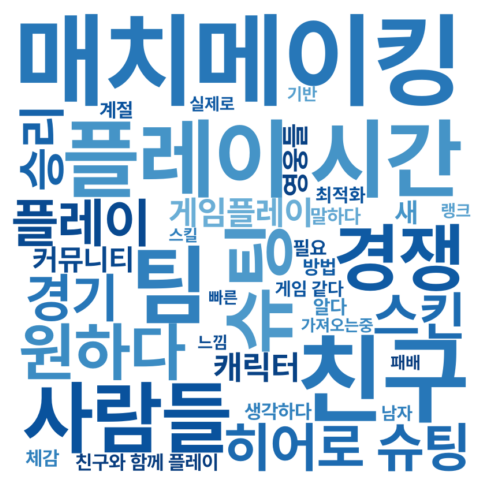

In [106]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex

font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
blues = cm.get_cmap("Blues")

def dark_blues(*args, **kwargs):
    return to_hex(blues(random.uniform(0.50, 0.98)))  # 0.70~0.98 구간만 사용(더 진함)

# 폰트 경로 (한글 표시 필수)
fontpath='C:/Users/user/Desktop/fonts/Pretendard-Bold.ttf'


# freq 딕셔너리 만들기
freq_dict = dict(zip(pos_df_kw["keyword_ko"][:40], pos_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_blues,
    collocations=False,
    relative_scaling=0.6,
    margin=0
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6 ,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

- 시스템/콘텐츠 만족
    - 매치메이킹, 경기, 랭크, 스킨, 캐릭터
    - 게임 구조나 경쟁 환경에서 긍정적 경험을 한 경우가 있다

- 소셜 플레이
    - 친구, 사람들, 팀, 커뮤니티
        - 협동/멀티플레이 경험이 긍정적으로 작용

- 몰입·시간
    - 플레이, 시간
        - 오랜 시간 즐겼다, 플레이 자체가 재미있었다는 리뷰가 많음

- 긍정 키워드 뉘앙스
    - 친구랑 같이 플레이
        - 전처리 과정에서도 이 키워드와 관련된 언급이 반복적으로 확인되었다
        - 친구와 같이 플레이하는 과정이 매우 긍정적인 평가로 다가왔다고 판단됨
    - 시간
        - 장시간 플레이할 만큼 만족했다는 맥락
    - 히어로, 캐릭터, 스킨
        - 워낙 마블 자체에 팬이 많다보니 마블 히어로가 중심인 게임을
        <br>플레이하는 것 자체가 긍정 요인으로 들어가는 경우가 많아보임

#### 부정

In [28]:
neg_df_kw = pd.read_csv("41-1. MR_리뷰_부정단어.csv", encoding="utf-8-sig")

In [29]:
neg_df_kw = neg_df_kw.drop([0,1,3,4,5,6,7,8,9,10,
                            11,12,13,16,18,19,
                            21,23,25,26,27,28,29,
                            31,32,33,34,35,36,37,38,
                            41,42,43,44,45,46,47,48,49,
                            51,52,53,54,55,56,57,59,
                            62,63,65,66,68,69,
                            70,71,74,75,76,77,78,79,
                            81,82,83,84,88,89,
                            92,94,95,96,
                            101,102,103,104,105,106,107,109,
                            113,115,116,117,118,119,
                            121,122,124,125,126,127,129,
                            130,132,133,134,135,136,137,138,139,
                            141,142,143,144,146,147,148,149,
                            150,151,152,153,154,156,157,158,159,
                            161,163,164,165,166,167,168,169,
                            170,171,172,173,174,176,177,178,
                            181,182,183,184,185,186,187,188,189,
                            190,191,192,193,194,196,197,198,199,
                            201,202,203,204,205,206,207,208,209,
                            210,211,212,213,214,215,216,217,218,219,
                            221,222,223,224,225,226,228,229,
                            230,231,232,233,234,236,237,238,239,
                            241,242,243,244,245,256,247,248,249,
                            250,251,252,253,254,255,256,257,259,
                            261,262,263,264,265,266,267,268,
                            270,271,272,273,274,275,276,277,278,279,
                            281,282,283,284,285,289,287,
                            290,292,293,294,297,298,299]).reset_index(drop=True)

In [30]:
neg_df_kw[61:80]

,keyword_en,keyword_ko,tfidf_mean
61,skin,피부,0.001572


In [31]:
neg_df_kw = neg_df_kw.drop([3,4,8,9,12,13,14,17,18,
                            21,28,41,45,47,52,55,57,]).reset_index(drop=True)

In [32]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].replace({
    "백성": "사람들",
    "정착하다":"수정하다",
    "싶다": "원하다",
    "계절":"시즌",
    "경쟁적인": "경쟁",
    "필요성": "필요",
    "기술": "스킬",
    "인물": "캐릭터",
    "금령": "차단",
    "성과, 성능": "성능",
    "파손되다": "튕기다",
    "언발란스": "밸런스 붕괴",
    "사유": "떠나다",
    "ELO": "랭크 점수",
    "파멸": "망치다",
    "약혼": "몰입도",
    "떠나기": "떠남",
    "피부": "스킨"
    })

In [34]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_19476\2817729366.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds = cm.get_cmap("Reds")


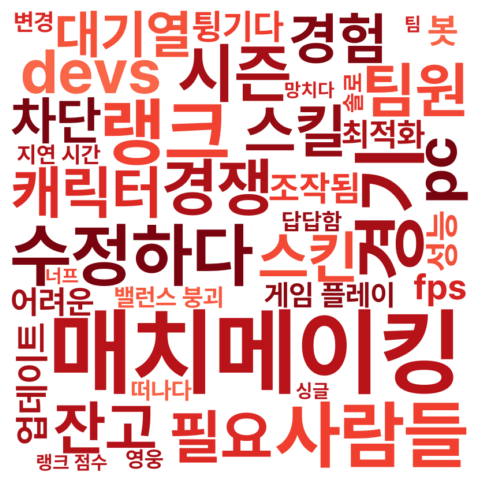

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex


font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
reds = cm.get_cmap("Reds")

def dark_reds(*args, **kwargs):
    return to_hex(reds(random.uniform(0.50, 0.98)))

# freq 딕셔너리 만들기
freq_dict = dict(zip(neg_df_kw["keyword_ko"][:40], neg_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_reds,
    collocations=False,
    relative_scaling=0.3
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

- 매칭,경쟁 시스템 불만
    - 매치메이킹, 랭크, 경쟁, 시즌, 점수(ELO), 필요하다, 차단
        - 여느 fps 게임들과 같이 매칭시스템에 상당한 불만을 가지고 있는 것으로 보임

- 팀플레이 갈등, 매크로(핵)유저와의 갈등
    - 사람들, 팀, 팀원, 캐릭터, 스킬, 영웅, 봇, 조작됨
        - 팀 기반 게임 특성상, 유저 간 협력 불만이 두드러짐
        - 팀원 때문에 진다, 사람들 실력 차이가 너무 난다, 봇(핵) 고쳐라 같은 맥락으로 해석 가능

- 게임 밸런스 & 캐릭터 문제
    - 밸런스 붕괴, 너프, 스킬, 캐릭터
        - 특정 영웅 OP(사기), 너프/버프 불만 → 지속적 밸런스 패치 요구

- 기술적 문제
    - PC, FPS, 지연 시간(렉), 최적화, 튕기다
        - 게임 환경 자체 불안정

- 개발자/운영 불신
    - devs(개발자들), 수정하다
        - 역시 개발자와 운영에 대한 불신의 리뷰가 있었음

#### 오버워치 vs 마블 라이벌스 리뷰 비교 인사이트

1. 긍정 비교

- **공통점**
    - 소셜 플레이와 팀 기반 경험
        - 오버워치 : 친구, 커뮤니티, 팀플레이 긍정 언급
        - 마블 라이벌스 : 친구랑 같이 플레이, 멀티플레이 경험 강조  
```두 게임 모두 협력 경험이 긍정 요인으로 작용```

    - 캐릭터/스킨 콘텐츠
        - 오버워치 : 영웅, 스킨 업데이트가 긍정 인식 강화
        - 마블 라이벌스 : 마블 IP 기반 히어로와 스킨이 긍정 요인  
```콘텐츠·IP 자체의 매력이 중요한 긍정 평가 축```

- **차이점**
    - 오버워치
        - 서버 안정성, 로딩 속도 개선 → UX/기술적 안정성이 긍정 요인으로 등장
        - PvP 대규모 경기 시스템(스타디움 모드 등)도 긍정적으로 언급됨


    - 마블 라이벌스
        - 장시간 플레이 자체를 긍정적으로 언급 → 몰입 경험이 강조됨
        - 마블 팬덤 효과가 강하게 작용 (히어로 자체가 긍정 요인)

2. 부정 비교

- **공통점**
    - 매치메이킹/랭크 불만
        - 오버워치 : 불공정 매칭, MMR 불투명, 신규/복귀 유저 보호 미흡
        - 마블 라이벌스: ELO 점수, 랭크 불만, 공정성 문제
<br> ```매칭 시스템 불신은 두 게임 공통의 핵심 부정 요인```

    - 팀플레이 갈등
        - 오버워치: 팀원 실력 차이, 비매너 플레이, 커뮤니티 갈등
        - 마블 라이벌스: 팀원 탓, 봇(핵), 실력 차이 불만
<br> ```팀 기반 게임 특성상 나타나는 보편적 불만```

    - 개발사/운영 불신
        - 오버워치: 제재 불투명성, 운영사 불신, 계정 상실 문제
        - 마블 라이벌스: 개발자(devs) 불만, 수정하라는 직접적 요구
<br> ```운영 신뢰 부족은 양쪽 모두 문제```

- **차이점**
    - 오버워치
        - 서버/네트워크, 로그인 인증 불안정 → 기술 인프라 관련 불만이 크게 드러남
        - 과금 구조에 대한 부정적 인식도 포함됨

    - 마블 라이벌스
        - 밸런스 불만이 더 강하게 드러남 (특정 영웅 OP, 너프/버프 피로)
        - 기술 문제는 최적화·FPS·튕김 같은 퍼포먼스 이슈에 집중
        - 핵/매크로 유저에 대한 불만이 자주 언급됨

3. 종합 비교 인사이트
    - **긍정의 차이**
        - 오버워치는 시스템 안정성·대규모 경기 구조 같은 기술·UX 기반 긍정이 두드러짐
        - 마블 라이벌스는 마블 IP 기반 캐릭터·장시간 몰입 경험이 긍정 축을 차지
<br> ```즉, 오버워치는 게임 시스템이 잘 돌아갈 때 긍정, 마블 라이벌스는 IP/콘텐츠 자체의 매력에서 긍정을 얻고 있음```

    - **부정의 차이**
        - 오버워치는 서버·인증·로그인 등 인프라 이슈와 과금 구조가 두드러짐
        - 마블 라이벌스는 밸런스 불만·핵 유저·최적화 문제가 강하게 드러남
<br> ```즉, 오버워치는 접속/운영 신뢰 문제가 크고, 마블 라이벌스는 게임 플레이 구조와 밸런스 신뢰 문제가 더 큼```

    - **공통 과제**
        - 매치메이킹 공정성, 팀플레이 갈등, 운영 불신은 두 게임 모두의 고질적 문제
        - FPS 기반 팀 게임에서 반복되는 패턴으로, 공정성과 신뢰 확보가 장르 공통의 핵심 과제임

### c. Red Dead Redemption 2 워드클라우드

In [63]:
# 리뷰 텍스트와 라벨만 따로 빼기
rdr_pn_word = rdr_text_m[['본문_번역', 'vader_label']]

In [64]:
# 중립 제외하기
rdr_pn_word = rdr_pn_word[rdr_pn_word['vader_label'].isin([0, 1])].copy()

In [65]:
import re
import numpy as np

def clean_text(text):
    # 문자열 변환
    text = str(text)
    
    # 한글, 영어, 공백만 남기기 (숫자, 특수문자 제거)
    text = re.sub(r'[^가-힣a-zA-Z\s]', ' ', text)
    
    # 다중 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 최종적으로 빈 문자열이면 NaN 반환 (필터링 가능)
    if text == "":
        return np.nan
    return text

In [66]:
rdr_pn_word["본문_번역"] = rdr_pn_word["본문_번역"].apply(clean_text)
rdr_pn_word = rdr_pn_word.dropna(subset=["본문_번역"]).reset_index(drop=True)

In [67]:
# 긍/부정 텍스트 합치기
rdr_pos_texts = rdr_pn_word[rdr_pn_word['vader_label'] == 1]['본문_번역'].apply(clean_text)
rdr_neg_texts = rdr_pn_word[rdr_pn_word['vader_label'] == 0]['본문_번역'].apply(clean_text)
print(len(rdr_pos_texts), len(rdr_neg_texts))

5881 1282


In [68]:
# TF-IDF로 상위 키워드 뽑기 (uni/bi-gram)
# Term Frequency,단어 빈도/ Inverse Document Frequency, 역문서 빈도
# 자주 나오지만 흔하지 않은 단어 → 높은 점수
# 자주 나오지만 흔한 단어 → 낮은 점수
from sklearn.feature_extraction.text import TfidfVectorizer

def top_keywords(texts, topk=30, ngram=(1,2)):
    # Series일 경우 리스트로 변환
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()
    if len(texts) == 0:
        return []

    vec = TfidfVectorizer(
        max_features=20000,
        ngram_range=ngram,
        stop_words='english'  # 영어 불용어 제거
    )
    X = vec.fit_transform(texts)
    vocab = vec.get_feature_names_out()
    scores = X.mean(axis=0).A1
    order = scores.argsort()[::-1][:topk]
    return [(vocab[i], float(scores[i])) for i in order]

# 사용 예시
rdr_pos_kw = top_keywords(rdr_pos_texts, topk=300, ngram=(1,2))
rdr_neg_kw = top_keywords(rdr_neg_texts, topk=300, ngram=(1,2))

print("POS top 5:", rdr_pos_kw[:5])
print("NEG top 5:", rdr_neg_kw[:5])

POS top 5: [('good', 0.08258615984641342), ('game', 0.07224948884585784), ('best', 0.05061594844371717), ('best game', 0.038730913075815776), ('good game', 0.02188950771870988)]
NEG top 5: [('game', 0.04286732857326256), ('dead', 0.03330310286683302), ('red', 0.03184555420552873), ('red dead', 0.03131137101345908), ('redemption', 0.0260052193563894)]


In [69]:
# 키워드 한글 번역 (무료 번역기 예시)

from deep_translator import MyMemoryTranslator

translator = MyMemoryTranslator(source='english', target='korean')

def translate_list(pairs):
    # pairs: [(keyword, score), ...]
    out = []
    for w, s in pairs:
        try:
            ko = translator.translate(w)
        except Exception:
            ko = ""  # 실패 시 빈 문자열
        out.append((w, ko, s))
    return out

rdr_pos_kw_ko = translate_list(rdr_pos_kw)
rdr_neg_kw_ko = translate_list(rdr_neg_kw)

# 미리보기
for w, ko, sc in rdr_pos_kw_ko[:10]:
    print(f"[POS] {w} -> {ko} ({sc:.4f})")
for w, ko, sc in rdr_neg_kw_ko[:10]:
    print(f"[NEG] {w} -> {ko} ({sc:.4f})")

[POS] good -> 선 (0.0826)
[POS] game -> 게임을 (0.0722)
[POS] best -> 제일 (0.0506)
[POS] best game -> 베스트 재밌는 게임 (0.0387)
[POS] good game -> 멋져요 (0.0219)
[POS] story -> 층 (cheung) (0.0194)
[POS] play -> 플레이 (0.0192)
[POS] great -> 위대한 (0.0191)
[POS] fun -> 재밌는 (0.0185)
[POS] masterpiece -> 명작 (0.0174)
[NEG] game -> 게임을 (0.0429)
[NEG] dead -> 죽은 (0.0333)
[NEG] red -> 빨간색 (0.0318)
[NEG] red dead -> 레드 데드 (0.0313)
[NEG] redemption -> 대속 (0.0260)
[NEG] dead redemption -> 데드 리뎀션 (0.0257)
[NEG] boring -> 지겨워요 (0.0164)
[NEG] rockstar -> 록스타 (0.0149)
[NEG] play -> 플레이 (0.0131)
[NEG] like -> 좋아요 (0.0117)


In [70]:
pos_df_kw = pd.DataFrame(rdr_pos_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])
neg_df_kw = pd.DataFrame(rdr_neg_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])

pos_df_kw.to_csv("41-2. RDR_리뷰_긍정단어.csv", index=False, encoding="utf-8-sig")
neg_df_kw.to_csv("41-2. RDR_리뷰_부정단어.csv", index=False, encoding="utf-8-sig")

print("저장 완료: 41-2. RDR_리뷰_긍정단어.csv / 41-2. RDR_리뷰_부정단어.csv")

저장 완료: 41-2. RDR_리뷰_긍정단어.csv / 41-2. RDR_리뷰_부정단어.csv


#### 긍정

In [71]:
pos_df_kw = pd.read_csv("41-2. RDR_리뷰_긍정단어.csv", encoding="utf-8-sig")

In [87]:
pos_df_kw = pos_df_kw.drop([0,1,2,3,4,6,7,8,9,10,
                            11,12,13,14,15,16,17,18,19,
                            21,22,23,25,26,27,28,29,
                            30,31,32,36,38,39,
                            41,42,43,45,46,47,48,49,
                            51,52,53,54,55,56,58,59,
                            62,63,64,65,67,68,69,
                            71,73,74,75,76,77,78,79,
                            81,82,83,86,87,88,89,
                            90,91,92,93,94,95,98,99,
                            101,102,103,104,107,108,109,
                            110,111,113,114,116,117,
                            121,122,123,124,125,128,129,
                            130,131,133,134,135,136,138,139,
                            141,143,144,145,147,148,149,
                            150,151,152,153,154,155,156,158,
                            161,162,163,164,165,167,169,
                            170,171,172,173,174,176,177,178,179,
                            181,182,183,184,185,186,187,188,189,
                            191,192,193,194,195,196,197,198,199,
                            202,203,204,205,206,207,208,209,
                            210,211,212,213,215,216,217,218,219,
                            221,222,224,225,226,227,228,229,
                            230,231,232,233,237,238,239,
                            243,244,245,246,247,248,249,
                            250,251,252,254,255,256,258,259,
                            261,265,267,268,269,
                            270,271,272,273,275,277,279,
                            281,282,283,284,285,287,288,289,
                            290,291,292,293,294,295,296,298,298,299]).reset_index(drop=True)

In [92]:
pos_df_kw[41:]

,keyword_en,keyword_ko,tfidf_mean
41,bought,구함,0.001878
42,liked,좋아요,0.001837
43,hunting,사냥,0.001771
44,start,시작,0.001709
45,work art,작업 예술,0.001703
46,chapter,장,0.001640
47,definitely,명확히,0.001598
48,sale,판매,0.001562
49,good graphics,우수한 그래픽,0.001511
50,western,서부,0.001510


In [93]:
pos_df_kw = pos_df_kw.drop([1,2,7,10,11,16,42,47,50,56,57,59,67]).reset_index(drop=True)

In [94]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].replace({
    "층 (cheung)": "스토리",
    "더 좋은": "개선되었다",
    "게임 시간": "플레이 타임",
    "문자": "캐릭터들",
    "구매": "살 가치가 있다",
    "문자": "캐릭터들",
    "스토리 게임": "스토리 중심 게임",
    "인물": "캐릭터",
    "종료": "엔딩",
    "백성": "사람들",
    "미술": "예술",
    "먼": "광활한",
    "말": "말들",
    "인생놀이": "인생 게임",
    "세부 사항": "디테일",
    "서쪽": "서부",
    "멋진 이야기": "훌륭한 스토리",
    "극장": "영화적 연출",
    "정말로": "사실적인",
    "싱글": "싱글 플레이",
    "구함": "구매했다",
    "작업 예술": "걸작",
    "장": "챕터",
    "판매": "할인",
    "가 격": "가격",
    "섬세하게": "디테일한",
    "대기": "몰입감",
    "완료": "클리어했다",
    "역학": "게임 매커니즘",
    "와일드웨스트": "서부 시대",
    "초": "두 번째",
    "단일 플레이어": "싱글 플레이어",
    "사명": "퀘스트",
    "앱솔루트 시네마": "완전 영화 같다"
    })

In [95]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_19476\4271752905.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


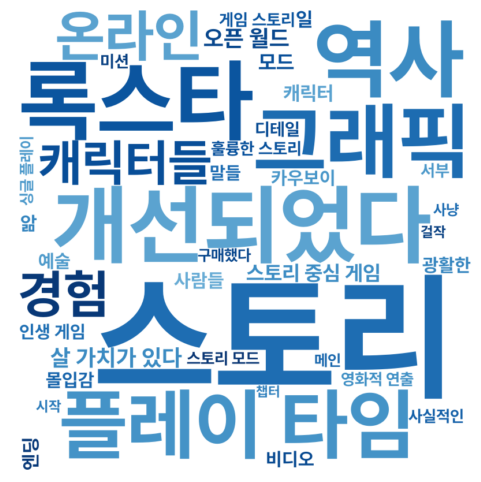

In [96]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex

font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
blues = cm.get_cmap("Blues")

def dark_blues(*args, **kwargs):
    return to_hex(blues(random.uniform(0.50, 0.98)))  # 0.70~0.98 구간만 사용(더 진함)

# 폰트 경로 (한글 표시 필수)
fontpath='C:/Users/user/Desktop/fonts/Pretendard-Bold.ttf'


# freq 딕셔너리 만들기
freq_dict = dict(zip(pos_df_kw["keyword_ko"][:40], pos_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_blues,
    collocations=False,
    relative_scaling=0.6,
    margin=0
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6 ,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

- 스토리 & 서사적 경험
    - 스토리, 스토리 모드, 스토리 중심 게임, 챕터, 역사
        - 사실적인 그래픽과 디테일, 압도적인 몰입감이 긍정적으로 언급
        - '스토리' 라는 단어를 충분히 지웠음에도 워드클라우드에 이만한 양이 나온 것으로 보면
        <br>유저들로 하여금 매우 강력한 인상을 남긴 것으로 보임
        - 비주얼 퀄리티 자체가 플레이어 만족도의 중요한 축이 됨

- 비주얼/연출
    - 그래픽, 사실적인, 디테일(디테일한), 영화적 연출, 비디오
        - 그래픽과 디테일에 대한 찬사는 압도적으로 많다
        - 단순히 '좋다' 수준이 아닌 예술 작품같은 그래픽과 연출로 언급됨

- 세계관/환경적 요소
    - 오픈 월드, 세계(월드), 서부
        - 서부 세계관과 오픈월드의 방대함이 긍정적으로 언급
        - 서부의 디테일한 생활감과 분위기가 플레이어 몰입을 강화함
        - 단순한 배경이 아니라 플레이 경험의 몰입을 강화하는 요소로 작동

- 플레이 경험/몰입감
    - 플레이 타임, 게임 시간, 경험, 온라인, 모드, 시작
        - 플레이 시간이 길지만 지루함보다 몰입감이 강조됨

- 캐릭터/정서적 애착
    - 캐릭터들, 캐릭터, 말들
        - 인물 묘사·등장인물의 매력에 대한 호평
        - 말들이 사랑스럽게 표현되는듯 함. 말에 대한 애정이 담긴 키워드들이 많았다

- 가치/구매/브랜드
    - 살 가치가 있다, 구매했다, 록스타, 개선되었다
        - '돈값 한다'는 인식과 제작사인 록스타 브랜드의 신뢰, 업데이트 개선을 체감하는 듯 하다.

#### 부정

In [97]:
neg_df_kw = pd.read_csv("41-2. RDR_리뷰_부정단어.csv", encoding="utf-8-sig")

In [116]:
neg_df_kw[280:300]

,keyword_en,keyword_ko,tfidf_mean
280,absolutely,절대적,0.001461
281,game just,game just,0.001460
282,open world,오픈 월드,0.001454
283,horrible,끔찍한,0.001450
284,players,플레이어,0.001445
285,use,사용,0.001434
286,leave,사유,0.001428
287,steal,스틸,0.001425
288,internet,가상공간,0.001424
289,cheater,사기꾼,0.001424


In [117]:
neg_df_kw = neg_df_kw.drop([0,1,2,3,4,5,7,8,9,
                            10,12,13,14,17,18,
                            22,23,25,26,27,28,29,
                            30,31,33,36,39,
                            41,42,43,44,45,46,47,48,49,
                            50,51,52,53,55,56,57,58,
                            61,62,63,64,65,66,67,69,
                            71,72,73,75,76,77,78,79,
                            81,83,84,85,86,87,88,
                            90,91,92,94,95,96,98,99,
                            101,102,103,105,106,108,
                            110,114,115,116,117,118,119,
                            121,133,124,125,126,127,128,
                            130,131,132,134,137,138,139,
                            140,141,143,144,145,146,147,
                            150,152,153,155,156,157,158,159,
                            160,161,162,163,164,165,166,167,168,169,
                            170,171,172,173,174,175,176,177,178,179,
                            180,181,182,183,184,187,189,
                            190,192,194,195,196,197,198,199,
                            200,201,203,204,206,207,208,209,
                            210,212,213,214,215,216,217,218,219
                            ,220,221,222,224,225,226,227,229,
                            230,231,232,233,234,237,238,239,
                            242,243,244,245,246,247,248,249,
                            250,252,253,254,255,256,257,258,259,
                            261,262,263,266,267,269,
                            270,271,272,273,274,275,276,277,278,279,
                            280,281,282,283,284,285,287,
                            290,292,293,285,286,297,298,299]).reset_index(drop=True)

In [123]:
neg_df_kw[60:]

,keyword_en,keyword_ko,tfidf_mean
60,frustrating,답답함,0.001506
61,mechanics,역학,0.001494
62,internet,가상공간,0.001424
63,cheater,사기꾼,0.001424
64,version,버전,0.001408
65,npc red,npc 레드,0.001399
66,company,기업,0.001396
67,miss,아가씨,0.001393


In [124]:
neg_df_kw = neg_df_kw.drop([0,6,13,20,32,53,66]).reset_index(drop=True)

In [125]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].replace({
    "층 (cheung)": "스토리",
    "파산함": "고장났다",
    "시작 관리자": "런처",
    "저기압": "다운된다",
    "백성": "사람들",
    "종료": "끝",
    "세상": "월드",
    "과오": "에러",
    "필요성": "필요하다",
    "account": "계정",
    "환불됨": "환불",
    "정착하다": "고쳐라",
    "사기꾼": "핵 유저",
    "컨트롤": "조작감",
    "분기": "챕터",
    "원하는": "수배",
    "아픈": "지겹다",
    "장": "챕터",
    "support": "고객 지원",
    "성업": "완료",
    "저장하기": "세이브",
    "충돌": "게임 튕김",
    "사교 클럽": "락스타 소셜 클럽",
    "세부 사상": "디테일",
    "문자": "캐릭터",
    "길을 잃어버림": "진행 불가",
    "커트": "컷신",
    "아픈": "지겹다",
    "역학": "게임 매커닉",
    "가상공간": "인터넷 연결 문제",
    "사기꾼": "핵 유저",
    "npc 레드": "NPC 버그",
    "아가씨": "누락"
    })

In [126]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_19476\2817729366.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds = cm.get_cmap("Reds")


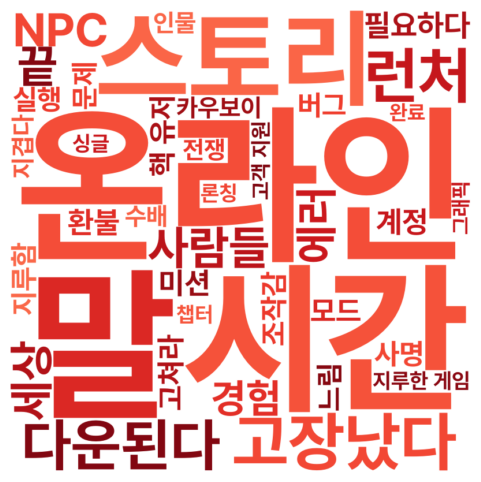

In [127]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex


font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
reds = cm.get_cmap("Reds")

def dark_reds(*args, **kwargs):
    return to_hex(reds(random.uniform(0.50, 0.98)))

# freq 딕셔너리 만들기
freq_dict = dict(zip(neg_df_kw["keyword_ko"][:40], neg_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_reds,
    collocations=False,
    relative_scaling=0.3
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

- 온라인/네트워크 문제
    - 온라인, 계정, NPC, 다운된다, 인터넷
        - 온라인 모드에서의 접속 문제, 계정 연동 불안정, NPC 동작 오류 등이 대표적 불만으로 드러남
        - 특히 '다운된다' 같은 표현은 크래시·튕김 문제를 지적하는 맥락으로 해석 가능

- 플레이 환경/기술적 문제
    - 말, 시간, 실행, 버그, 고장났다, 런처, 완료
        - 말(horse) 관련 버그나 사망 문제, 플레이 시간 소모에 대한 불만,
        <br>런처 오류 및 실행 불안정, 버그·고장 문제 전반이 포함됨
        - 그래픽 카드가 많이 중요한 게임이다보니
        <br>단순히 콘텐츠보다 기술적 안정성에 대한 부정이 두드러진다

- 스토리/콘텐츠 관련
    - 스토리, 인물, 미션, 사명, 챕터, 경험, 카우보이, 전쟁, 싱글
        - 스토리와 미션은 긍정 평가에서 압도적으로 나왔지만
        <br>긴 분량 때문인지 지루하다/길다/늘어진다는 부정 맥락의 리뷰도 작성됨

- 사용자 경험(UX) 불만
    - 지루한 게임, 사람들, 핵 유저
        - UX 전반에서 불편함이 언급됨
        - 멀티플레이어 환경에서 다른 유저나 핵 유저와의 갈등이 있음


#### 오버워치 vs RDR2 리뷰 비교 인사이트

1. 긍정 비교

- **공통점**
    - 강한 몰입/참여 경험
        - 오버워치 : 팀 기반 플레이/커뮤니티/리그 참여가 긍정 요인
        - 마블 라이벌스 : 스토리 몰입/서부 세계관/사실적인 그래픽이 긍정 요인  
        ```
        두 게임 모두 두 게임 모두 경험의 깊이가 핵심 만족 요인
        <br>다만 오버워치는 협력,경쟁 중심이면 RDR2는 스토리 중심
        ```

    - 콘텐츠 자체의 매력
        - 오버워치 : 영웅/스킨 업데이트 → 꾸준한 콘텐츠 신선도 유지
        - 마블 라이벌스 : 영화적 그래픽/오픈월드/스토리 디테일 → 작품성 인식
        ```
        전자는 라이브 서비스형 업데이트, 후자는 완결형 작품성으로 긍정 반응 차별화
        ```

- **차이점**
    - 오버워치
        - 팀 기반 경쟁의 짜릿함
            - 협동과 경쟁의 균형이 주는 만족
            - e스포츠/토너먼트 경험이 긍정 인식 강화
        - 지속 업데이트의 신뢰
            - 영웅 추가, 밸런스 패치, 스킨 업데이트가 운영되는 게임 인식 형성

    - RDR2
        - 몰입감 있는 서사
            - 영화·드라마 같은 내러티브 체험이 만족 요인
        - 압도적인 비주얼과 연출
            - 게임을 예술작품으로 받아들이게 만듦
        - 세계관 체험 가치
            - 플레이어를 실제 서부에 던져놓은 듯한 체험

2. 부정 비교

- **공통점**
    - 기술적 안정성 불만
        - 오버워치 : 서버 불안정, 로그인/매칭 지연
        - 마블 라이벌스 : 런처 오류, 버그, 튕김/다운 문제  
        ```
        두 게임 모두 기술 인프라 불안정이 부정적 경험을 크게 만든다는 점에서 공통
        ```

- **차이점**
    - 오버워치
        - 핵심 이슈: 매칭/밸런스 불공정
        - 팀원 간 실력 차이, 비매너 유저, 제재 불투명성 → 커뮤니티 신뢰 약화
        - 운영/과금 정책에 대한 불신도 드러남

    - RDR2
        - 핵심 이슈: 콘텐츠 길이와 피로감
        - 스토리가 압도적 긍정에도 불구하고 일부 유저는 '길고 지루하다'라는 불만 표출
            - 게임을 예술작품으로 받아들이게 만듦
        - 온라인 모드에서의 계정/핵 유저 문제, 싱글 플레이 환경의 기술적 문제 등도 추가 불만

3. 종합 비교 인사이트
    - **긍정의 차이**
        - 오버워치는 팀 기반 경쟁으로 친구, 팀원과의 협력, 승리 경험, 커뮤니티 이벤트가 긍정의 핵심임
        - RDR2는 스토리 중심 게임으로 탄탄한 스토리라인과 영화적 연출, 그에 상응하는 그래픽이 예술작품급으로 호평을 받고 있음

        ```오버워치는 사회적 플레이와 지속성이 긍정, RDR2는 개인적 몰입과 예술적 완성도에서 긍정을 얻고 있음```

    - **부정의 차이**
        - 오버워치는 매칭 불균형과 운영에 대한 불신, 기술적 문제가 부정 요인으로 드러남
        - RDR2는 탈것의 사망과 버그, 런처 오류, 방대한 스토리 분량에 대한 피로감이 부정 요인으로 드러남
        ```
        오버워치는 불균형한 매칭과 네트워크 인프라 문제가 크고, RDR2는 스토리 분량과 기술적인 불안정함이 더 큼
        ```

    - **공통 과제**
        - 두 게임 모두 멀티플레이 신뢰 회복과 기술적 안정이 시급하다
        - 유저 피드백 반영과 운영 투명성이 공통 과제이다.

### d. PUBG 워드클라우드

In [128]:
# 리뷰 텍스트와 라벨만 따로 빼기
pubg_pn_word = pubg_text_m[['본문_번역', 'vader_label']]

In [130]:
# 중립 제외하기
pubg_pn_word = pubg_pn_word[pubg_pn_word['vader_label'].isin([0, 1])].copy()

In [131]:
import re
import numpy as np

def clean_text(text):
    # 문자열 변환
    text = str(text)
    
    # 한글, 영어, 공백만 남기기 (숫자, 특수문자 제거)
    text = re.sub(r'[^가-힣a-zA-Z\s]', ' ', text)
    
    # 다중 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 최종적으로 빈 문자열이면 NaN 반환 (필터링 가능)
    if text == "":
        return np.nan
    return text

In [132]:
pubg_pn_word["본문_번역"] = pubg_pn_word["본문_번역"].apply(clean_text)
pubg_pn_word = pubg_pn_word.dropna(subset=["본문_번역"]).reset_index(drop=True)

In [133]:
# 긍/부정 텍스트 합치기
pubg_pos_texts = pubg_pn_word[pubg_pn_word['vader_label'] == 1]['본문_번역'].apply(clean_text)
pubg_neg_texts = pubg_pn_word[pubg_pn_word['vader_label'] == 0]['본문_번역'].apply(clean_text)
print(len(pubg_pos_texts), len(pubg_neg_texts))

8184 1741


In [134]:
# TF-IDF로 상위 키워드 뽑기 (uni/bi-gram)
# Term Frequency,단어 빈도/ Inverse Document Frequency, 역문서 빈도
# 자주 나오지만 흔하지 않은 단어 → 높은 점수
# 자주 나오지만 흔한 단어 → 낮은 점수
from sklearn.feature_extraction.text import TfidfVectorizer

def top_keywords(texts, topk=30, ngram=(1,2)):
    # Series일 경우 리스트로 변환
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()
    if len(texts) == 0:
        return []

    vec = TfidfVectorizer(
        max_features=20000,
        ngram_range=ngram,
        stop_words='english'  # 영어 불용어 제거
    )
    X = vec.fit_transform(texts)
    vocab = vec.get_feature_names_out()
    scores = X.mean(axis=0).A1
    order = scores.argsort()[::-1][:topk]
    return [(vocab[i], float(scores[i])) for i in order]

# 사용 예시
pubg_pos_kw = top_keywords(pubg_pos_texts, topk=300, ngram=(1,2))
pubg_neg_kw = top_keywords(pubg_neg_texts, topk=300, ngram=(1,2))

print("POS top 5:", pubg_pos_kw[:5])
print("NEG top 5:", pubg_neg_kw[:5])

POS top 5: [('received free', 0.15166177870293074), ('product received', 0.15165022705447795), ('received', 0.1516076673249636), ('product', 0.15039575763937896), ('free', 0.14960547044550526)]
NEG top 5: [('game', 0.04198977533799454), ('cheaters', 0.02585400279579707), ('bad', 0.020872503111751782), ('shit', 0.018263203738164584), ('pubg', 0.014957946466886548)]


In [135]:
# 키워드 한글 번역 (무료 번역기 예시)

from deep_translator import MyMemoryTranslator

translator = MyMemoryTranslator(source='english', target='korean')

def translate_list(pairs):
    # pairs: [(keyword, score), ...]
    out = []
    for w, s in pairs:
        try:
            ko = translator.translate(w)
        except Exception:
            ko = ""  # 실패 시 빈 문자열
        out.append((w, ko, s))
    return out

pubg_pos_kw_ko = translate_list(pubg_pos_kw)
pubg_neg_kw_ko = translate_list(pubg_neg_kw)

# 미리보기
for w, ko, sc in pubg_pos_kw_ko[:10]:
    print(f"[POS] {w} -> {ko} ({sc:.4f})")
for w, ko, sc in pubg_neg_kw_ko[:10]:
    print(f"[NEG] {w} -> {ko} ({sc:.4f})")

[POS] received free -> 무료로 받음 (0.1517)
[POS] product received -> 제품 수령 완료 (0.1517)
[POS] received -> 지불됨 (0.1516)
[POS] product -> 상품 (0.1504)
[POS] free -> 무료 (0.1496)
[POS] good -> 선 (0.1154)
[POS] game -> 게임을 (0.0429)
[POS] fun -> 재밌는 (0.0270)
[POS] nice -> 좋은 (0.0262)
[POS] good game -> 멋져요 (0.0221)
[NEG] game -> 게임을 (0.0420)
[NEG] cheaters -> 사기꾼 (0.0259)
[NEG] bad -> 나쁨 (0.0209)
[NEG] shit -> 염병 (0.0183)
[NEG] pubg -> PUBG (0.0150)
[NEG] play -> 플레이 (0.0138)
[NEG] good -> 선 (0.0112)
[NEG] cheater -> 사기꾼 (0.0104)
[NEG] cheat -> 사기 (0.0103)
[NEG] just -> 오직 (0.0101)


In [136]:
pos_df_kw = pd.DataFrame(pubg_pos_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])
neg_df_kw = pd.DataFrame(pubg_neg_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])

pos_df_kw.to_csv("41-3. PUBG_리뷰_긍정단어.csv", index=False, encoding="utf-8-sig")
neg_df_kw.to_csv("41-3. PUBG_리뷰_부정단어.csv", index=False, encoding="utf-8-sig")

print("저장 완료: 41-3. PUBG_리뷰_긍정단어.csv / 41-3. PUBG_리뷰_부정단어.csv")

저장 완료: 41-3. PUBG_리뷰_긍정단어.csv / 41-3. PUBG_리뷰_부정단어.csv


#### 긍정

In [31]:
pos_df_kw = pd.read_csv("41-3. PUBG_리뷰_긍정단어.csv", encoding="utf-8-sig")

In [32]:
pos_df_kw[280:]

,keyword_en,keyword_ko,tfidf_mean
280,free great,무료 훌륭함,0.000481
281,learn,알아보기,0.000481
282,fucking,bil-eo meog-eul,0.000480
283,best fps,최고의 FPS,0.000479
284,thanks,감사합니다.,0.000474
285,poorly,빈곤,0.000471
286,update,업데이트,0.000471
287,did,했다,0.000467
288,pubg pubg,pubg pubg,0.000465
289,hile,hile,0.000464


In [33]:
pos_df_kw = pos_df_kw.drop([0,1,2,3,4,5,6,7,8,9,
                            10,11,12,13,14,15,16,17,18,19,
                            20,21,22,23,24,26,27,28,29,
                            30,31,32,33,34,35,36,37,39,
                            40,41,42,43,45,46,47,48,49,
                            50,51,52,53,54,55,56,57,58,59,
                            60,61,62,63,64,65,66,68,69,
                            71,72,73,74,75,76,77,79,
                            80,82,83,84,85,86,88,89,
                            91,92,93,94,95,96,97,98,99,
                            100,101,102,103,104,105,106,107,108,109,
                            110,112,113,114,115,116,117,118,119,
                            121,122,123,124,126,127,128,129,
                            130,131,132,133,134,135,136,137,139,
                            141,142,143,145,146,147,148,
                            150,151,152,153,155,156,157,158,159,
                            160,161,163,164,165,166,167,
                            171,172,173,174,175,176,177,178,
                            180,181,182,183,184,185,186,187,188,189,
                            190,195,196,197,198,199,
                            200,202,203,204,205,206,207,208,209,
                            210,212,213,214,215,216,217,219,
                            200,221,223,224,225,226,228,229,
                            230,231,232,233,234,235,236,237,238,239,
                            240,241,242,243,244,245,247,248,249,
                            250,251,253,253,254,255,257,258,259,
                            263,264,266,267,268,269,
                            271,272,273,274,276,278,279,
                            280,281,282,283,284,285,286,287,288,289,
                            290,292,293,294,296,298,299]).reset_index(drop=True)

In [34]:
pos_df_kw = pos_df_kw.drop([8,20,29,33]).reset_index(drop=True)

In [35]:
pos_df_kw

,keyword_en,keyword_ko,tfidf_mean
0,friends,친구,0.004656
1,battle royale,배틀로얄,0.002690
2,fps,fps,0.002343
3,graphics,그래픽,0.001668
4,realistic,사실적,0.001633
5,years,년,0.001441
6,people,백성,0.001385
7,mobile,모바일,0.001309
8,optimized,최적화됨,0.000974
9,shooting,촬영,0.000907


In [37]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].replace({
    "사실적": "사실적인",
    "년": "오랜 기간",
    "스리랑카": "참여하다",
    "백성": "유저들",
    "최적화됨": "최적화",
    "촬영": "슈팅",
    "경기": "매치",
    "닭고기": "치킨",
    "STABLE": "안정적",
    "가지": "클래식",
    "지도": "맵",
    "횟수": "플레이 시간",
    "실선": "안정적이다",
    "돈": "과금",
    "분대": "스쿼드",
    "강렬한": "긴장감 넘치는",
    "것": "요소",
    "community": "커뮤니티",
    "플러스": "장점",
    "중 다음과 일치 :": "매치들"
    })

In [38]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_4488\2279857146.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


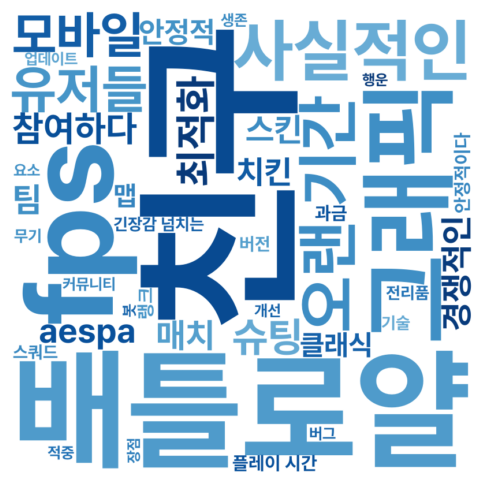

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex
from matplotlib import font_manager

font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
blues = cm.get_cmap("Blues")

def dark_blues(*args, **kwargs):
    return to_hex(blues(random.uniform(0.50, 0.98)))  # 0.70~0.98 구간만 사용(더 진함)

# 폰트 경로 (한글 표시 필수)
fontpath='C:/Users/user/Desktop/fonts/Pretendard-Bold.ttf'


# freq 딕셔너리 만들기
freq_dict = dict(zip(pos_df_kw["keyword_ko"][:40], pos_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_blues,
    collocations=False,
    relative_scaling=0.6,
    margin=0
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6 ,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

- 게임 모드/장르
    - 배틀로얄, FPS, 생존, 매치, 스쿼드
    - 배틀로얄 장르의 특성(생존, 긴장감, 경기 매치 등)이 긍정적으로 작용
    - 특히 FPS 기반 슈팅 경험과 스쿼드 팀플레이는 PUBG만의 핵심 강점으로 언급됨

- 플레이 경험/몰입감
    - 슈팅, 명중, 긴장감 넘치는, 플레이 시간, 참여하다
        - 총격/슈팅의 손맛과 명중의 쾌감이 주요 긍정 요소로 작용
        - 단순한 플레이가 아니라 긴장감 넘치는 몰입 경험으로 언급됨

- 기술/성능
    - 안정적, 최적화, 최적화됨, 개선, 업데이트, 버전
        - PUBG에 대한 긍정 키워드에는 기술적 안정성도 중요한 평가 기준
        - 안정적, 최적화 같은 단어는 성능 문제 해결이나
        <br>업데이트를 통해 게임이 개선되었다는 맥락

- 세계관/환경
    - 맵, 지도, 전리품(루트), 무기, 스킨
        - 오픈 맵 구조와 다양한 무기/루팅 경험이 긍정적으로 언급
        - 스킨은 단순 미적 요소가 아닌, 플레이어들의 개성을 드러내는 중요한 만족 요인이 됨

- 커뮤니티/소셜 요소
    - 친구, 유저들, 팀, 커뮤니티
        - 함께하는 경험이 핵심 긍정 요소로 작용
        - 특히 '친구와 팀플레이'가 긍정 경험을 크게 강화하는 것으로 해석됨
        - 커뮤니티 기반 소통도 긍정적인 영향을 줌

- 기타/브랜드/문화적 요소
    - 모바일, aespa, 행운, 과금, 요소
        - '모바일' 은 모바일 배틀그라운드를 지칭하는 듯 하며
        <br>이 키워드가 긍정 워드클라우드에 잡혔다는 것은 게임의 접근성과 확장성이 긍정적으로 평가되었다는 것을 시사함.
        - aespa는 최근 콜라보레이션을 진행한 아이돌 에스파를 언급하는 리뷰들로, 이 이벤트가 유저들에게 긍정적인 반응을 불러일으켰다는 것을 알 수 있음
        - '행운'은 배틀로얄 특유의 변동성과 운 요소가 긍정적으로 언급된 맥락
        - '과금'은 긍정/부정 양면으로 맥락이 있을 수 있지만
        <br>여기서는 '과금 별로 안했는데 높은 확률의 상품을 뽑았다' 정도로 해석 가능

#### 부정

In [63]:
neg_df_kw = pd.read_csv("41-3. PUBG_리뷰_부정단어.csv", encoding="utf-8-sig")

In [65]:
neg_df_kw = neg_df_kw.drop([0,2,3,4,5,6,7,8,9,
                            11,12,13,14,15,16,18,19,
                            21,22,23,24,25,26,27,28,29,
                            31,32,33,34,35,36,37,38,
                            40,41,42,43,44,45,46,47,48,49,
                            50,52,54,55,56,57,58,59,
                            60,61,62,63,66,67,68,69,
                            70,72,73,74,75,76,77,78,79,
                            80,81,82,83,84,85,86,88,89,
                            91,93,95,97,98,
                            101,102,103,104,106,107,109,
                            111,113,114,116,117,118,
                            120,121,123,124,125,126,128,129,
                            130,132,133,134,135,136,138,139,
                            142,145,146,147,148,
                            150,151,152,153,154,155,156,157,159,
                            161,162,163,165,166,169,
                            170,171,175,176,177,178,179,
                            180,181,182,183,184,185,186,187,188,189,
                            194,196,197,198,199,
                            200,204,205,206,207,209,
                            212,213,214,216,218,219,
                            220,221,222,223,224,225,226,227,228,229,
                            230,231,233,234,235,236,237,238,239,
                            240,241,242,243,244,245,246,247,248,249,
                            250,252,253,254,256,258,259,
                            261,262,263,265,266,267,
                            270,272,273,274,277,278,
                            281,282,283,285,285,287,288,289,
                            290,291,292,293,295,296,297,298,299]).reset_index(drop=True)

In [66]:
neg_df_kw[60:90]

,keyword_en,keyword_ko,tfidf_mean
60,community,community,0.001252
61,problems,갈등,0.001248
62,updates,업데이트,0.001240
63,install,설치,0.001215
64,greedy,욕심쟁이,0.001215
65,random,무작위,0.001205
66,server,서버,0.001205
67,matter,물질,0.001192
68,version,버전,0.001189
69,support,support,0.001154


In [67]:
neg_df_kw = neg_df_kw.drop([8,36]).reset_index(drop=True)

In [68]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].replace({
    "사기꾼": "핵 유저",
    "차단됨": "계정 정지",
    "지연 시간": "서버 지연",
    "파손되다": "게임 튕김",
    "새": "신규 업데이트 불만",
    "경기": "매치",
    "구매하기": "과금",
    "지도": "맵",
    "과오": "오류",
    "정착하다": "고치다",
    "깨진": "망가진",
    "developers": "개발자들",
    "트릭": "핵",
    "account": "계정 문제",
    "방울": "드랍",
    "전리품": "파밍 불만",
    "막힘": "이동 막힘",
    "금지 사유": "부당 밴",
    "처치": "킬 관련 불만",
    "유지": "반복되는",
    "역학": "게임 매커니즘",
    "영역": "자기장",
    "리코일": "반동",
    "hacks": "핵 프로그램",
    "지출": "과금 유도",
    "community": "커뮤니티",
    "갈등": "문제",
    "욕심쟁이": "돈만 밝힘",
    "물질": "문제",
    "support": "고객 지원"
    })

In [69]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_4488\2817729366.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds = cm.get_cmap("Reds")


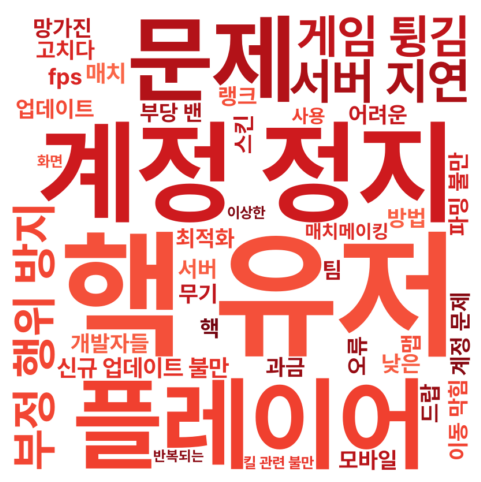

In [70]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex


font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
reds = cm.get_cmap("Reds")

def dark_reds(*args, **kwargs):
    return to_hex(reds(random.uniform(0.50, 0.98)))

# freq 딕셔너리 만들기
freq_dict = dict(zip(neg_df_kw["keyword_ko"][:40], neg_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_reds,
    collocations=False,
    relative_scaling=0.3
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

- 핵/부정행위 관련
    - 핵, 유저, 계정, 정지, 밴, 과금, 반복되는, 사용
        - 핵 유저 문제와 계정 정지 논란이 가장 큰 불만 요소로 드러남
        - 핵 유저 관련 언급은 반복적으로 나타났으며,
        <br>전체 부정 리뷰에서 가장 핵심적이고 상징적인 불만 요소임을 보여준다 

- 기술적 문제
    - 서버, 지연, 튕김, 망가진, 고치다, 최적화, 파밍 불만, 화면, 이동 막힘
        - 접속 지연, 튕김, 최적화 부족 같은 기술적 불안정이 자주 언급됨
        - 특히 에임, 이동 막힘, 파밍 불만 등 플레이 중 일어나는 자잘한 버그들이 자주 언급되었음

- 게임 플레이 환경
    - 플레이어, 팀, 매치, fps, 랭크, 무기, 킬 관련 불만
        - 기본적인 매치·랭크 시스템, FPS 특성에 따른 밸런스 불만이 포함됨

- 운영 및 업데이트
    - 문제, 개발자들, 업데이트, 신규 업데이트, 불만
        - 개발자 및 운영에 대한 불신, 업데이트 방향성에 대한 불만
        - 신규 업데이트가 문제를 해결하기보다는 오히려 새로운 불만을 만든다는 지적이 반영됨

#### 오버워치 vs RDR2 리뷰 비교 인사이트

1. 긍정 비교

- **공통점**
    - 강한 몰입/참여 경험
        - 오버워치 : 팀 기반 플레이/커뮤니티/리그 참여가 긍정 요인
        - PUBG : 생존 긴장감, 슈팅 손맛, 스쿼드 협력
        ```
        두 게임 모두 몰입과 긴장 속에서의 참여 경험을 긍정적으로 평가
        ```

    - 콘텐츠 지속성/매력
        - 오버워치 : 영웅/스킨 업데이트를 통한 꾸준한 콘텐츠 신선도 유지
        - PUBG : 무기·맵·스킨, 모바일 확장성 등으로 매력 강화
        ```
        꾸준히 즐길 거리와 볼거리를 제공한다는 점이 공통된 긍정 축
        ```

- **차이점**
    - 오버워치
        - 사회적 플레이·경쟁 구조가 핵심
        <br>(팀워크, e스포츠, 지속 패치)
    - PUBG
        - 장르적 특성과 문화 확장성이 핵심
        <br>(배틀로얄 생존 경험, 모바일 버전, 아이돌 콜라보)

2. 부정 비교

- **공통점**
    - 기술적 안정성 문제가 반복적으로 지적
        - 오버워치 : 서버 불안정, 로그인/매칭 지연
        - PUBG : 튕김, 최적화 부족, 렉 
        ```
        '플레이 환경이 불안정하다'는 점이 공통 불만
        ```
    - 운영 불신
        - 오버워치 : 제재 불투명, 과금 구조 논란
        - PUBG: 운영/개발자 불신, 업데이트 불만
        ```
        '운영 투명성과 신뢰 부족'은 공통 과제
        ```

- **차이점**
    - 오버워치
        - 매칭 불균형, 실력 격차, 팀플레이 갈등

    - PUBG
        - 핵 유저 문제(부정 리뷰의 핵심), 파밍/무기 밸런스 불만

3. 종합 비교 인사이트
    - **긍정의 차이**
        - 두 게임 모두 몰입·참여 경험과 콘텐츠 매력이 공통 긍정 요인이지만,
        <br>오버워치는 사회적 플레이/경쟁, PUBG는 장르적 몰입/문화 확장성에서 긍정 차별화가 나타남

    - **부정의 차이**
        - 기술적 안정성과 운영 불신은 공통되지만,
        <br>오버워치는 매칭 불공정, PUBG는 핵 유저 문제가 결정적 차별화 포인트임

    - **공통 과제**
        - 두 게임 모두 멀티플레이 신뢰 회복, 기술 안정성 확보, 운영 투명성 강화에 힘을 쏟아야 한다.